# Sentiment_Analysis_of_Movie_Reviews


![img.webp](attachment:img.webp)
- This project focuses on classifying movie reviews from the IMDB dataset using the Naive Bayes classification algorithm, specifically the Multinomial Naive Bayes variant.
- The IMDB dataset is a popular benchmark dataset for sentiment analysis. It consists of 50,000 movie reviews, split evenly into training and testing sets. Each review is labeled as either "positive" or "negative".
- The goal is to develop a model that can accurately predict whether a given movie review is positive or negative based on the text content.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Stage 1 : Dataset Preparation and Importing libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score

## Load the dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Text(0.5, 1.0, 'Sentiment distribution')

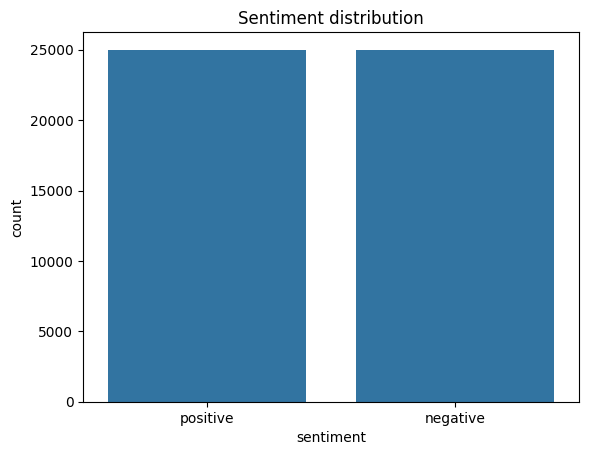

In [6]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment distribution")

## Explore review

In [7]:
for i in range(5):
    print("Review: ", [i])
    print(df['review'].iloc[i], "\n")
    print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [8]:
df.isnull().sum()

,0
review,0
sentiment,0


## Function to count number of words in each review

In [9]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [10]:
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


## Remove Duplicate rows

In [11]:
print('Number of Duplicate reviews:',df.duplicated().sum())

Number of Duplicate reviews: 418


In [12]:
df = df.drop_duplicates('review')
len(df)

49582

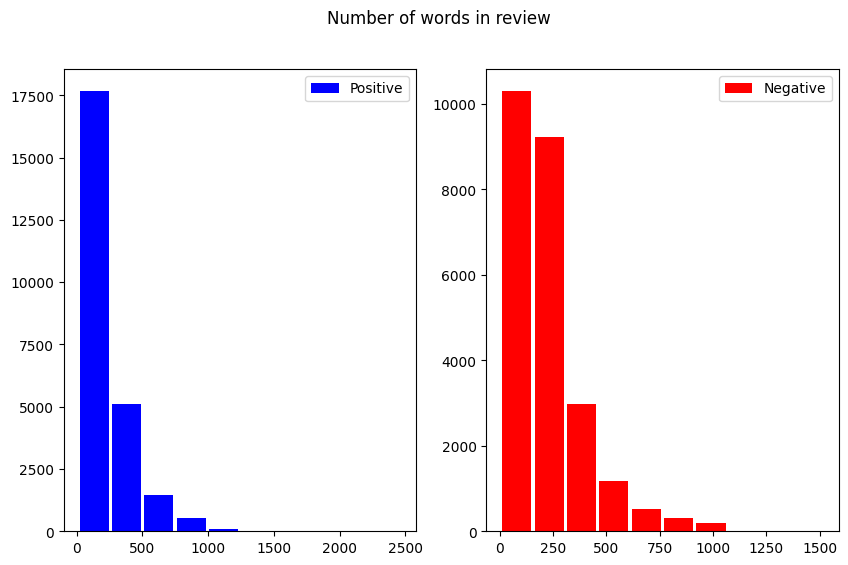

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()

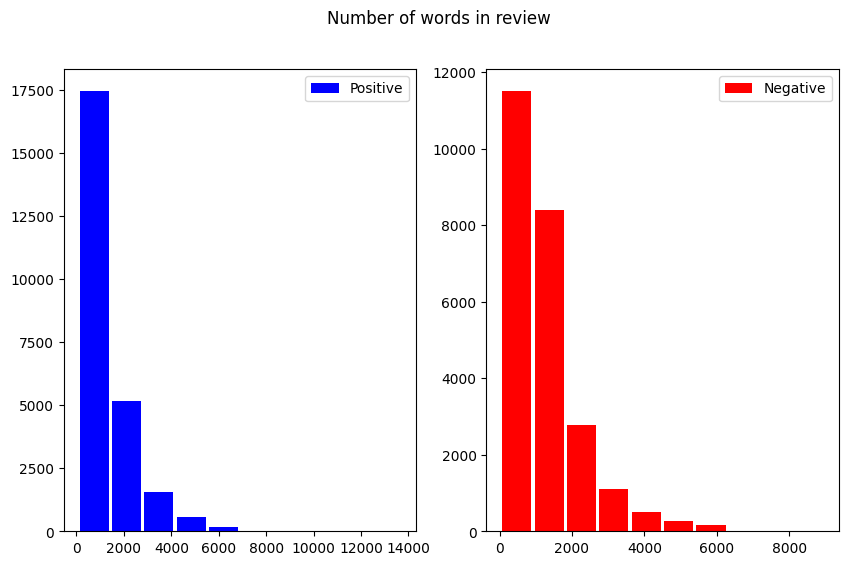

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['review'].str.len(), label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['review'].str.len(), label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()


# Stage 2 : Text Preprocessing

In [17]:
# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()


def text_preprocessing(text):
    text =text.lower()

    # Removing punctuation

    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stop words
    filtered_text = [word for word in tokens if word not in stop_words]


    # Joining the tokens back into a single string
    return " ".join(filtered_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
# Apply text preprocessing
df['review'] = df['review'].apply(text_preprocessing)

# Stage 3: Apply Stemming and  Tokenization

In [19]:
#stemming
ps = PorterStemmer()
def stemming(data):
    tokens = word_tokenize(data)
    #text = [stemmer.stem(word) for word in data]
    filtered_text = [ps.stem(word) for word in tokens]

    return " ".join(filtered_text)


In [20]:
df['review'] = df['review'].apply(lambda x: stemming(x))


In [21]:
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,one review mention watch 1 oz episod youll hoo...,positive,168
1,wonder littl product film techniqu unassum old...,positive,84
2,thought wonder way spend time hot summer weeke...,positive,86
3,basic there famili littl boy jake think there ...,negative,67
4,petter mattei love time money visual stun film...,positive,125


## Label Encoding

In [22]:
le = LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

In [23]:
df.head()

,review,sentiment,word count
0,one review mention watch 1 oz episod youll hoo...,1,168
1,wonder littl product film techniqu unassum old...,1,84
2,thought wonder way spend time hot summer weeke...,1,86
3,basic there famili littl boy jake think there ...,0,67
4,petter mattei love time money visual stun film...,1,125


In [24]:
pos_reviews =  df[df.sentiment == 1]
pos_reviews.head()

,review,sentiment,word count
0,one review mention watch 1 oz episod youll hoo...,1,168
1,wonder littl product film techniqu unassum old...,1,84
2,thought wonder way spend time hot summer weeke...,1,86
4,petter mattei love time money visual stun film...,1,125
5,probabl alltim favorit movi stori selfless sac...,1,58


In [25]:
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('film', 48843),
 ('movi', 42896),
 ('one', 26837),
 ('like', 19812),
 ('time', 15400),
 ('see', 14626),
 ('good', 14507),
 ('stori', 13606),
 ('charact', 13567),
 ('make', 13114),
 ('great', 12721),
 ('get', 12527),
 ('watch', 12425),
 ('love', 12015),
 ('well', 11261)]

In [26]:
pos_words = pd.DataFrame(count.most_common(15))
pos_words.columns = ['word', 'count']
pos_words.head()

,word,count
0,film,48843
1,movi,42896
2,one,26837
3,like,19812
4,time,15400


In [27]:
import plotly.express as px
px.bar(pos_words, x='count', y='word', title='Common words in positive reviews', color = 'word').show()

In [28]:
neg_reviews =  df[df.sentiment == 0]
neg_reviews.head()

,review,sentiment,word count
3,basic there famili littl boy jake think there ...,0,67
7,show amaz fresh innov idea 70 first air first ...,0,83
8,encourag posit comment film look forward watch...,0,64
10,phil alien one quirki film humour base around ...,0,51
11,saw movi 12 came recal scariest scene big bird...,0,84


In [29]:
count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('movi', 55299),
 ('film', 42590),
 ('one', 25417),
 ('like', 23648),
 ('make', 15265),
 ('get', 14971),
 ('even', 14935),
 ('watch', 14383),
 ('good', 14192),
 ('time', 14151),
 ('bad', 13966),
 ('charact', 13774),
 ('would', 13483),
 ('see', 12708),
 ('realli', 12085)]

In [30]:
neg_words = pd.DataFrame(count.most_common(15))
neg_words.columns = ['word', 'count']
neg_words.head()

,word,count
0,movi,55299
1,film,42590
2,one,25417
3,like,23648
4,make,15265


In [31]:
px.bar(neg_words, x='count', y='word', title='Common words in positive reviews', color = 'word').show()

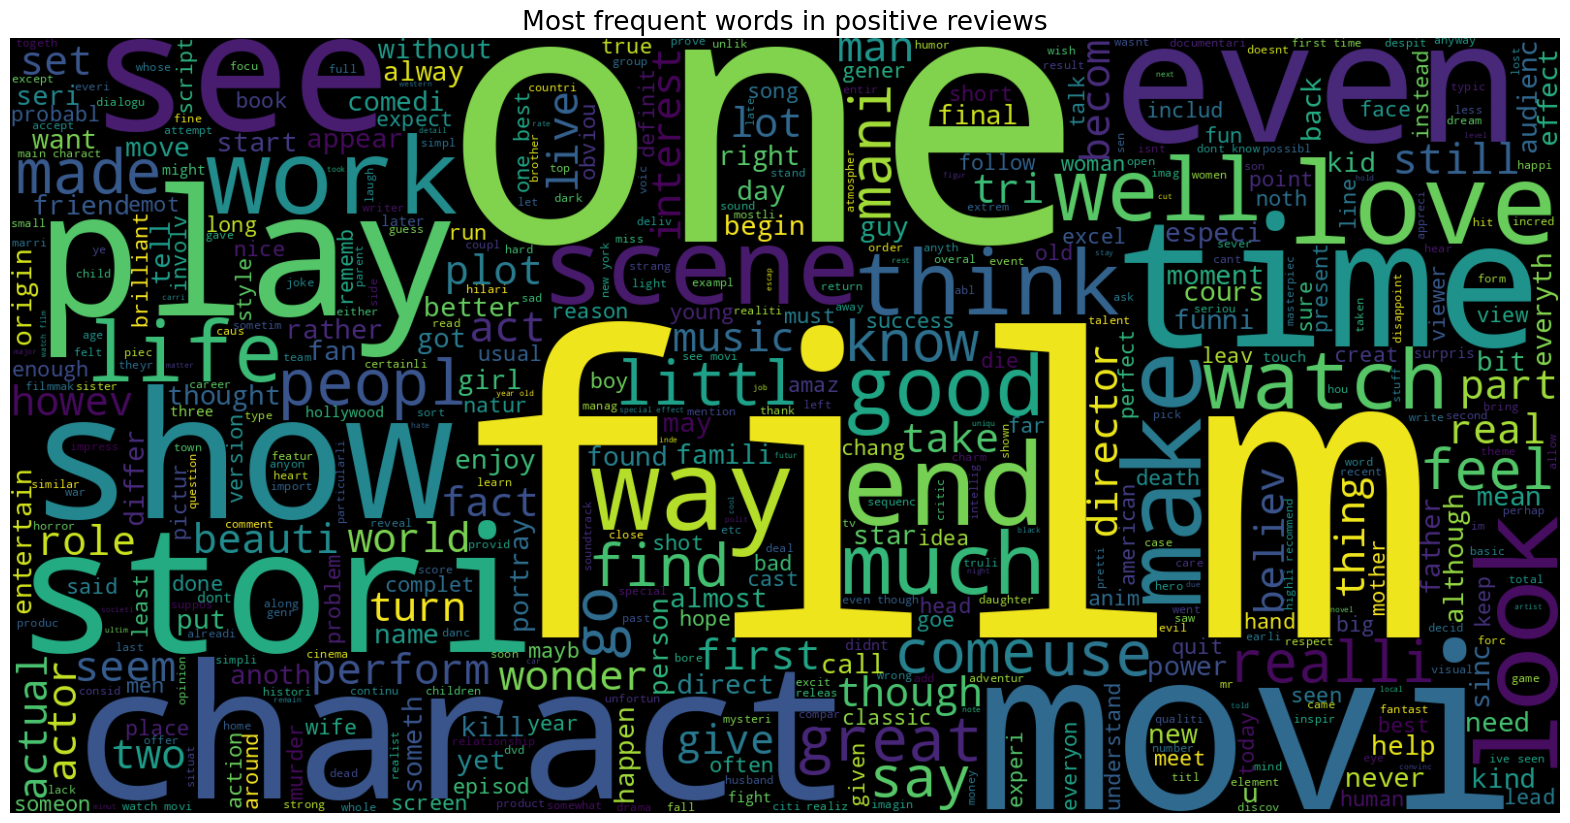

In [32]:
from wordcloud import WordCloud

text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

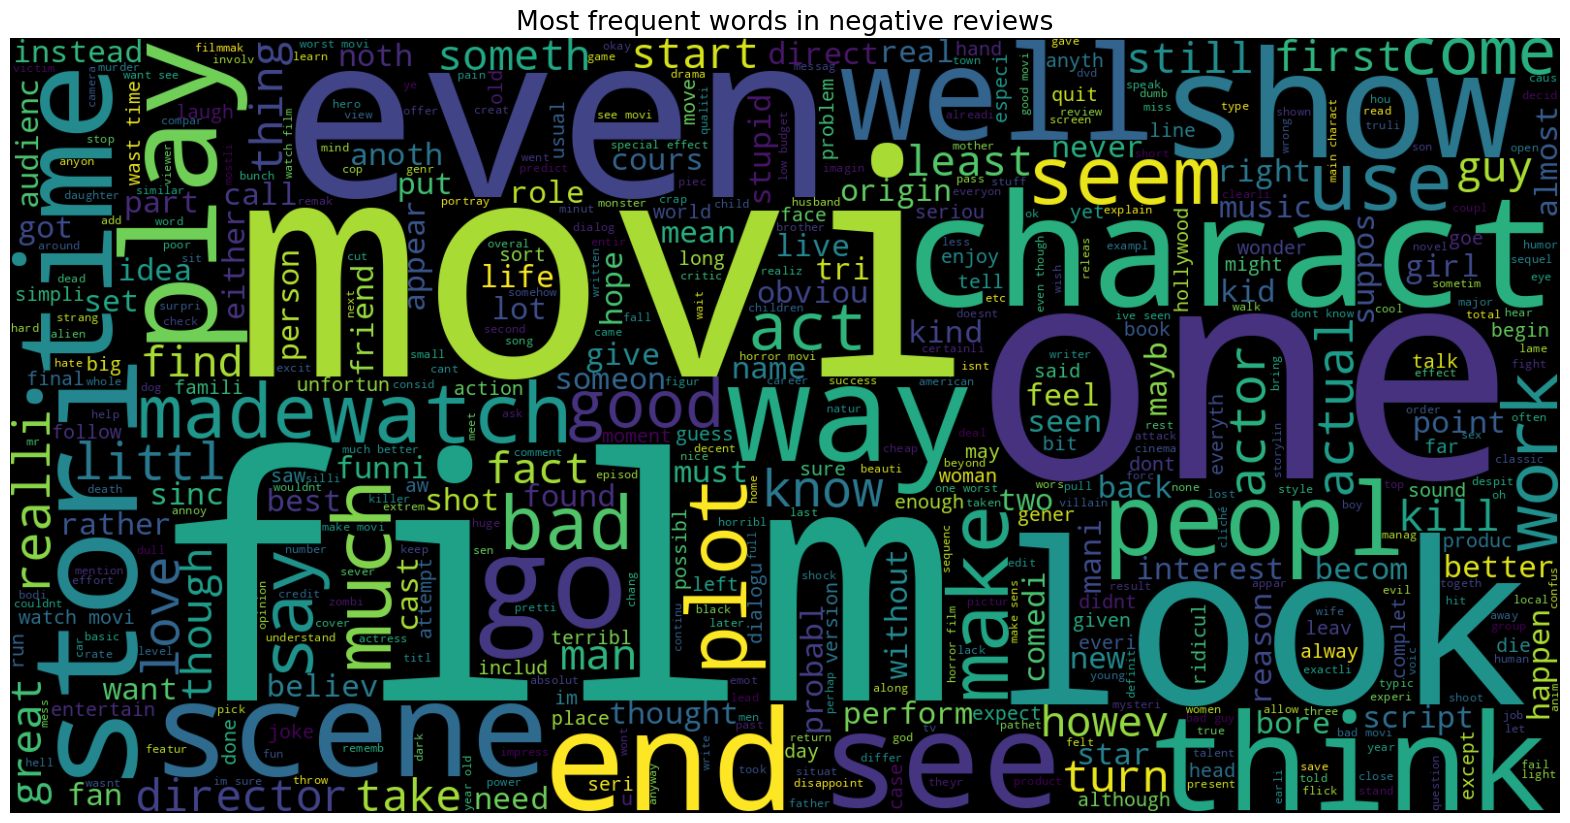

In [33]:
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

# Stage 4 : Feature Extraction

In [34]:
x = df['review']
y = df['sentiment']

## Use TF-IDF to transorm text data into numerical feature vector

In [35]:
vect = TfidfVectorizer(max_features=10000)
x = vect.fit_transform(df['review'])

In [36]:
from joblib import dump

# Save the model to a file
dump(vect, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

# Stage 5 : Naive Bayes Classification

## Split Dataset

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [38]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (34707, 10000)
Size of y_train:  (34707,)
Size of x_test:  (14875, 10000)
Size of y_test:  (14875,)


## Train the Model

In [39]:
gnb = MultinomialNB()
gnb.fit(x_train.toarray(), y_train)

MultinomialNB()

In [40]:
# Save the trained model to a file
dump(gnb, 'naive_bayes_model.joblib')

['naive_bayes_model.joblib']

## Prediction on training and test data

In [41]:
y_train_pred = gnb.predict(x_train.toarray())
y_test_pred = gnb.predict(x_test.toarray())

In [42]:
y_test_pred

array([0, 1, 1, ..., 1, 1, 0])

# Stage 6 : Model Evaluation

## Calculate evaluation metrics

In [43]:
print("Training Confusion matrix is\n {}  \nTest Confusion matrix is \n{}".format(confusion_matrix(y_train, y_train_pred),confusion_matrix(y_test, y_test_pred)))
print('\n\ntraining score: %.3f, test score: %.3f' % ( accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_test_pred)))
print('\n\nprecision triaining score: %.3f, precision test score: %.3f' % (precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)))
print('\n\nrecall training score: %.3f,recall test score: %.3f' % (recall_score(y_train,y_train_pred),recall_score(y_test, y_test_pred)))
print('\n\nf1 training score: %.3f,f1 test score: %.3f' % (f1_score(y_train,y_train_pred),f1_score(y_test, y_test_pred)))

Training Confusion matrix is
 [[15099  2195]
 [ 2226 15187]]  
Test Confusion matrix is 
[[6293 1111]
 [1067 6404]]


training score: 0.873, test score: 0.854


precision triaining score: 0.874, precision test score: 0.852


recall training score: 0.872,recall test score: 0.857


f1 training score: 0.873,f1 test score: 0.855


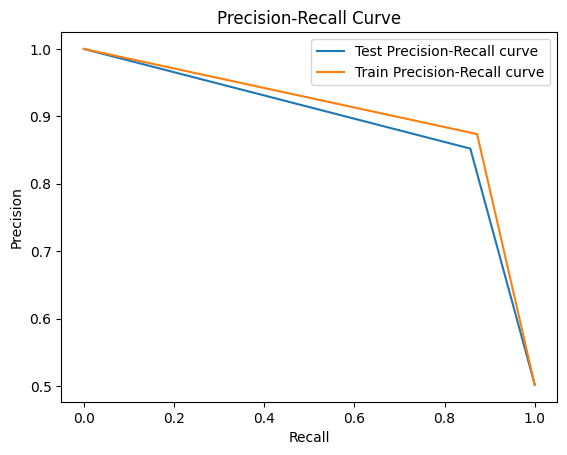

In [44]:

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
precision1, recall1, _ = precision_recall_curve(y_train, y_train_pred)

# Plot the precision-recall curve
plt.plot(recall, precision,label='Test Precision-Recall curve')
plt.plot(recall1, precision1,label='Train Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

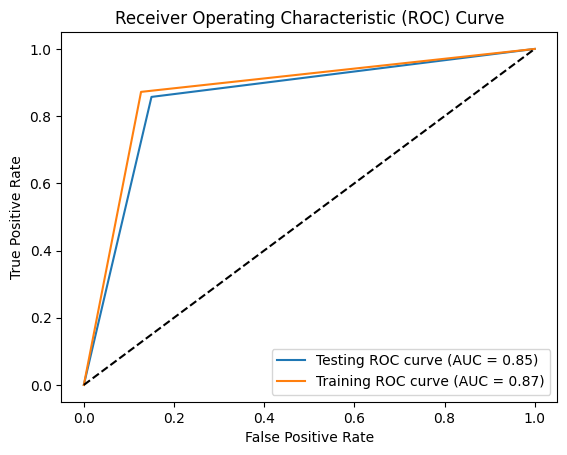

In [45]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
fpr1, tpr1, thresholds1 = roc_curve(y_train, y_train_pred)

# Compute the area under the ROC curve
auc = roc_auc_score(y_test, y_test_pred)
auc1 = roc_auc_score(y_train, y_train_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'Testing ROC curve (AUC = {auc:.2f})')
plt.plot(fpr1, tpr1, label=f'Training ROC curve (AUC = {auc1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Use Cross Validation

In [46]:
def cv_acc(model):
    acc = cross_val_score(model, x_train.toarray(),y_train, scoring="accuracy", cv=5)
    return (acc)
cv_score = cv_acc(gnb)
cv_score.mean()

0.8530841357814772

# Stage 7: Prediction with new data

In [47]:
def predict_sentiment(review):
    preprocessed_review = text_preprocessing(review)
    stem_review = stemming(preprocessed_review)
    review_vector = vect.transform([stem_review])
    predicted_sentiment = gnb.predict(review_vector)[0]
    sentiment_label = "Positive" if predicted_sentiment == 1 else "Negative"
    return sentiment_label

In [48]:
# User interaction in the command-line interface
def user_interface():
    print("Sentiment Prediction - Movie Reviews")
    print("-----------------------------------")
    print("Enter 'exit' to quit.")

    while True:
        review = input("\nEnter your movie review: ")
        if review.lower() == "exit":
            break
        sentiment = predict_sentiment(review)
        print("Predicted sentiment:", sentiment)


## Command Line Interface

In [49]:
# Run the command-line interface
user_interface()

Sentiment Prediction - Movie Reviews
-----------------------------------
Enter 'exit' to quit.

Enter your movie review: the movie is interesting 
Predicted sentiment: Negative

Enter your movie review: the movie is amazing
Predicted sentiment: Positive

Enter your movie review: the movie is not amazing
Predicted sentiment: Positive

Enter your movie review: the movies is bad
Predicted sentiment: Negative

Enter your movie review: exit
